In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import torch
torch.cuda.empty_cache()

In [3]:
path= !pwd; 
print(path)



['/home/nms105/course-v3/nbs/Gamma']


In [4]:
path_lbl = '/home/nms105/course-v3/nbs/Gamma/labels'
path_img ='/home/nms105/course-v3/nbs/Gamma/images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/nms105/course-v3/nbs/Gamma/images/150.png'),
 PosixPath('/home/nms105/course-v3/nbs/Gamma/images/149.png'),
 PosixPath('/home/nms105/course-v3/nbs/Gamma/images/148.png')]

In [6]:
fnames[0]

PosixPath('/home/nms105/course-v3/nbs/Gamma/images/150.png')

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/nms105/course-v3/nbs/Gamma/labels/150.png'),
 PosixPath('/home/nms105/course-v3/nbs/Gamma/labels/149.png'),
 PosixPath('/home/nms105/course-v3/nbs/Gamma/labels/147.png')]

/home/nms105/course-v3/nbs/Gamma/images/94.png


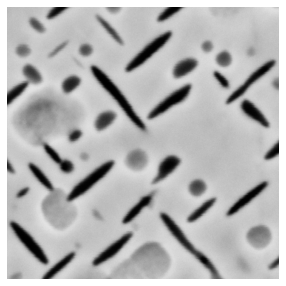

In [8]:
img_f = fnames[40]
img = open_image(img_f)
img.show(figsize=(5,5));print(img_f)


In [9]:
get_y_fn = lambda x: Path(str(x).replace('images', 'labels'))

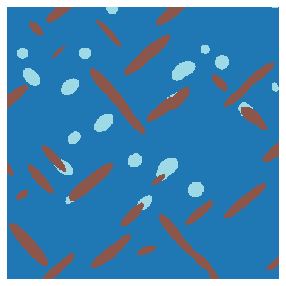

In [10]:
mask = open_mask(get_y_fn(img_f))

mask.show(figsize=(5,5), alpha=1)


In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([448, 448]),
 tensor([[[0, 0, 0,  ..., 2, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [12]:
codes = np.loadtxt('codes.txt', dtype=str); codes


array(['BG', 'GammaDoublePrime', 'GammaPrime', 'Void'], dtype='<U16')

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free < 8200: bs=4
else:           bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")


using bs=16, have 12187MB of GPU RAM free


In [14]:
size
# tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.02, max_warp=0.)

array([224, 224])

In [15]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [16]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

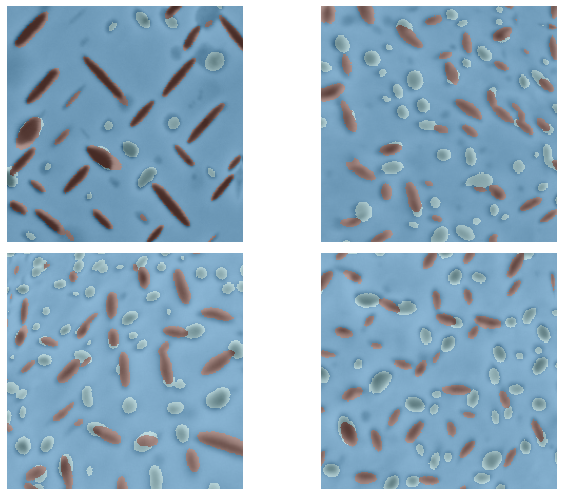

In [17]:
data.show_batch(2, figsize=(10,7))

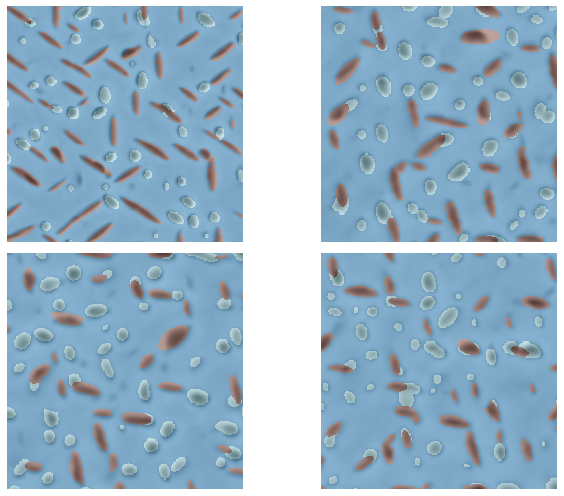

In [18]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [19]:
# name2id = {v:k for k,v in enumerate(codes)}
def dice1(pred, targs):
    pred_prime = (pred>0).float()
    
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)
#     targs=(targs>0).float() 
#     return 2. * (pred*targs).sum() / (pred+targs).sum()


def acc_camvid1(input:Tensor, targs:Tensor) -> Rank0Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
#     target = target.squeeze(1)

#     mask = target 
    return (input[targs]==targs[targs]).float().mean()

def myaccuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    targs = targs.squeeze(1)
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)


In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
wd=1e-2

In [22]:
learn = unet_learner(data, models.resnet34, metrics= acc_camvid, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


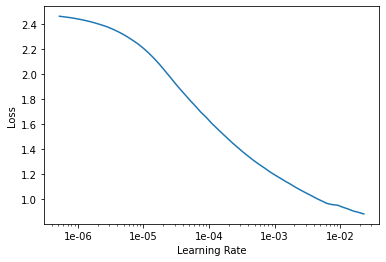

In [23]:
lr_find(learn)
fig1= learn.recorder.plot(9, figsize=(1,0.5), return_fig=True)
fig1.savefig('fig1.png', dpi=200)

In [24]:
lr=5e-4

In [25]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [35]:
#learn.recorder.plot_metrics(sho)
#learn.recorder.plot_losses()
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

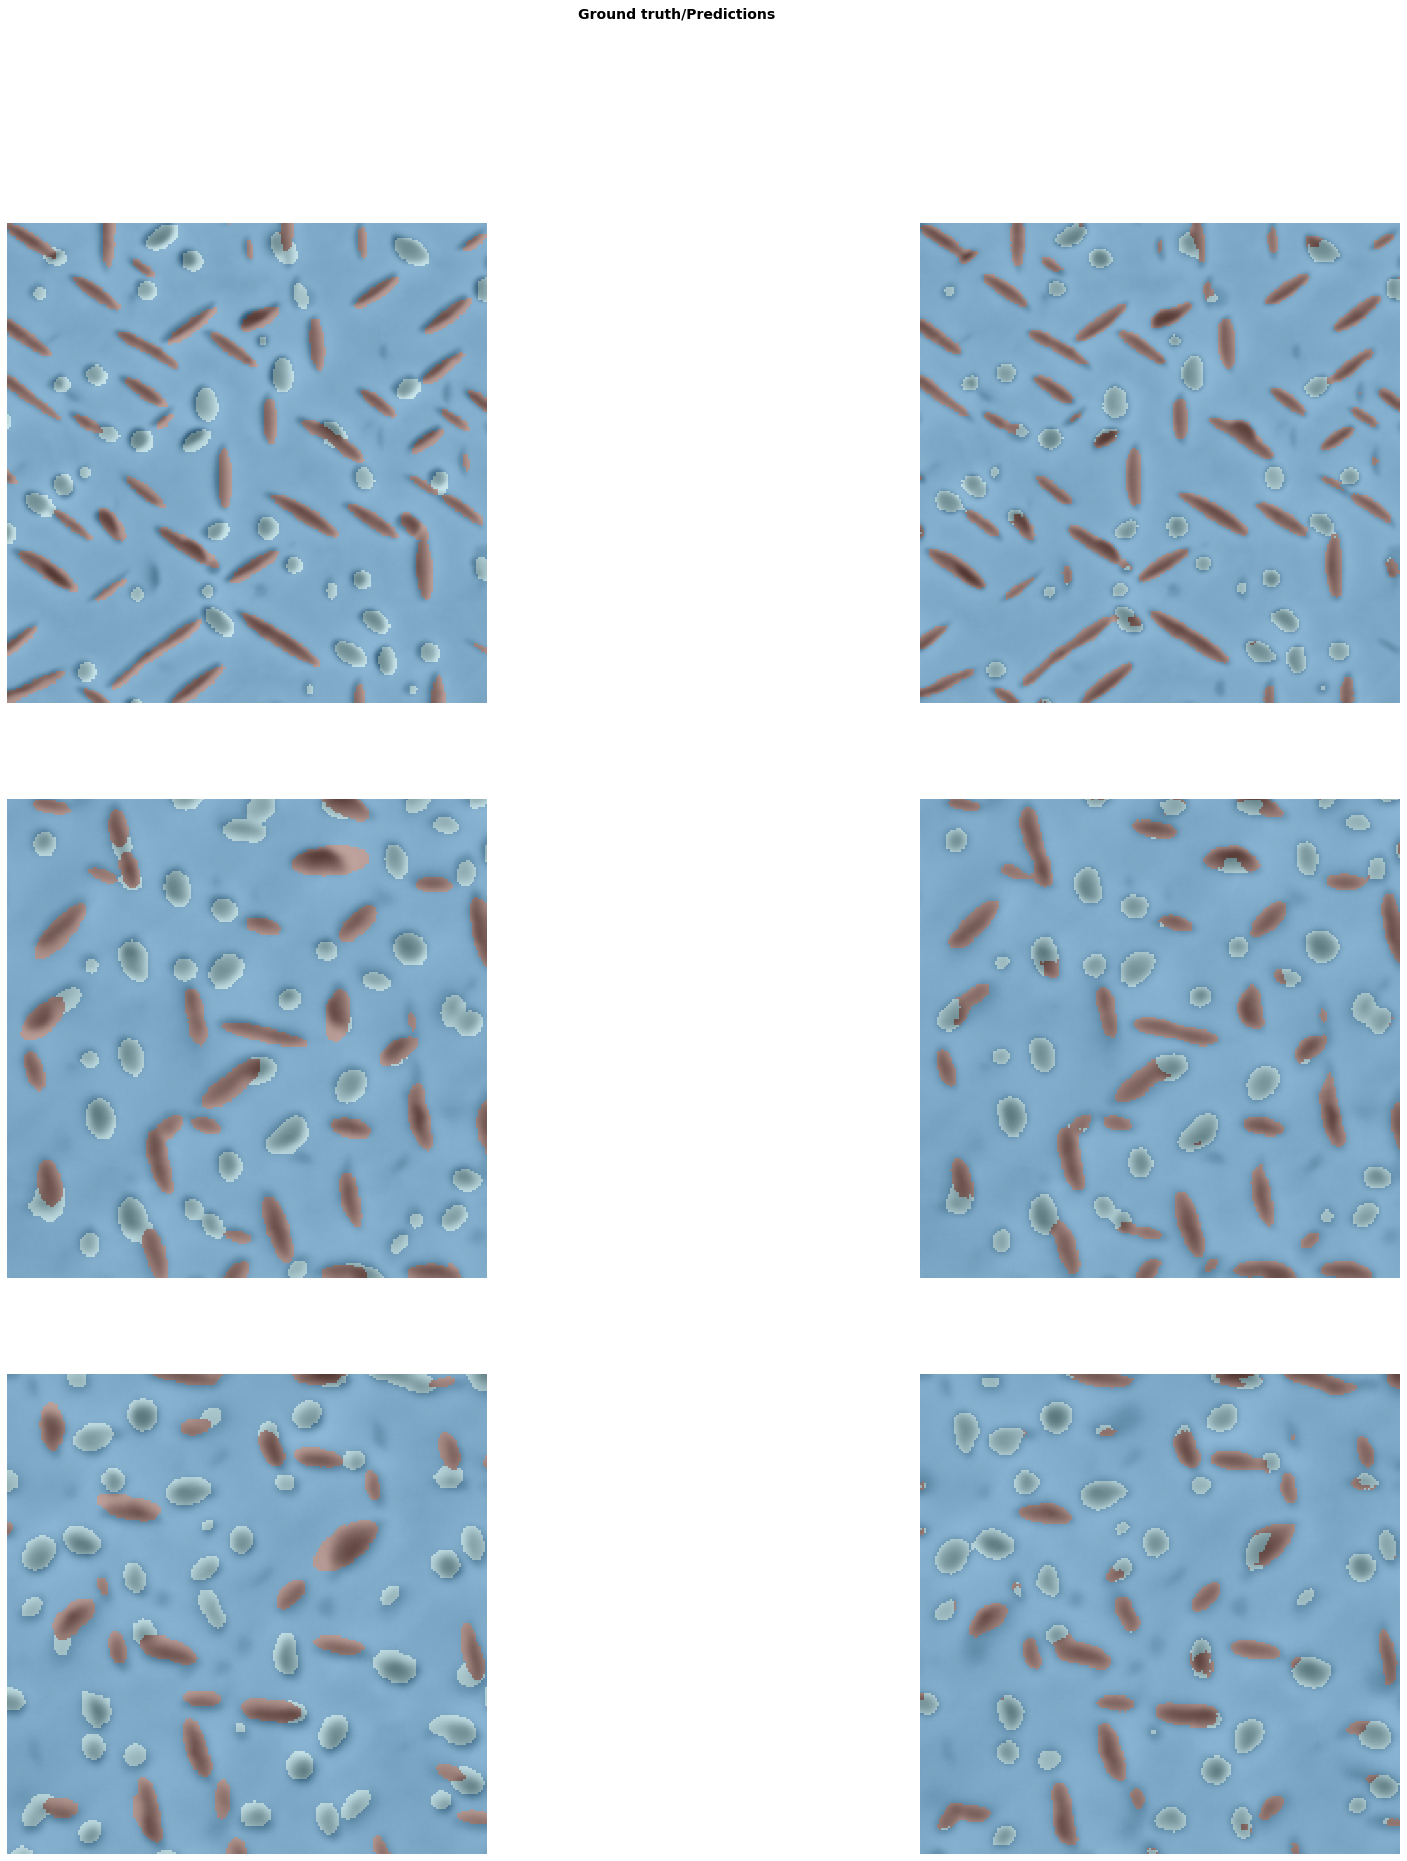

In [46]:
learn.show_results(rows=3, figsize=(30,30))

In [29]:
 for index, layer in enumerate(learn.layer_groups):
  print('Layer Group Index: ', index, layer)

Layer Group Index:  0 Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-

In [73]:
learn.save('stage-1')

In [74]:
learn.unfreeze()

In [75]:
lrs = slice(lr)

In [76]:
learn.fit_one_cycle(10, lrs, pct_start=0.9)

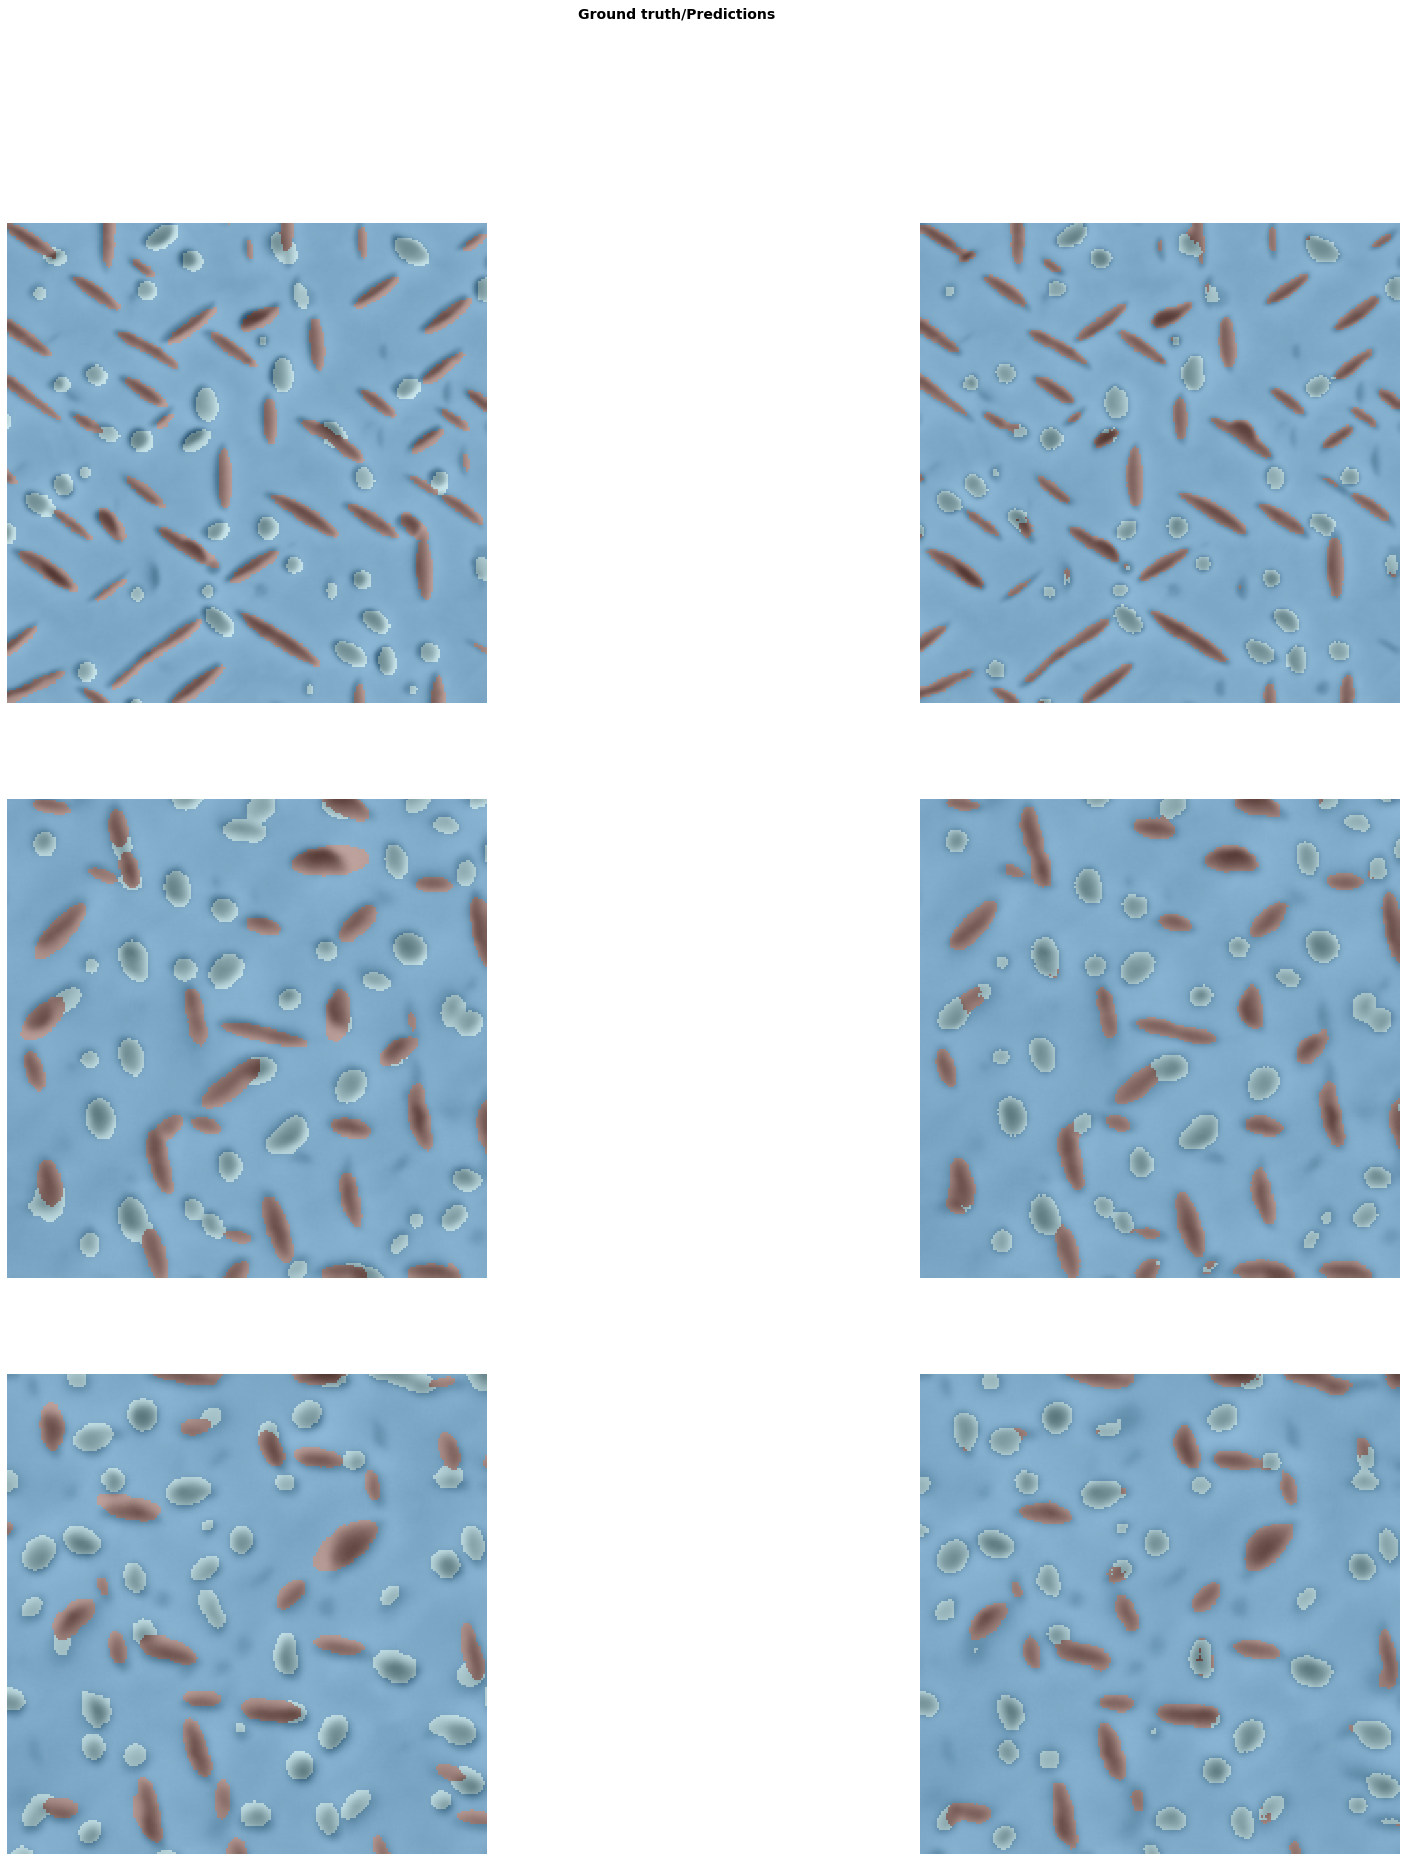

In [77]:
learn.show_results(rows=3, figsize=(30,30))



In [78]:
learn.save('stage-2');

In [80]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")
size

using bs=8, have 10256MB of GPU RAM free


array([448, 448])

In [81]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [82]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)

In [83]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


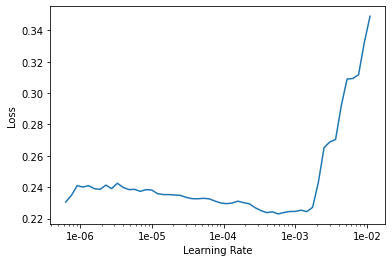

In [84]:
lr_find(learn)
learn.recorder.plot()

In [87]:
lr=1e-4

In [88]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

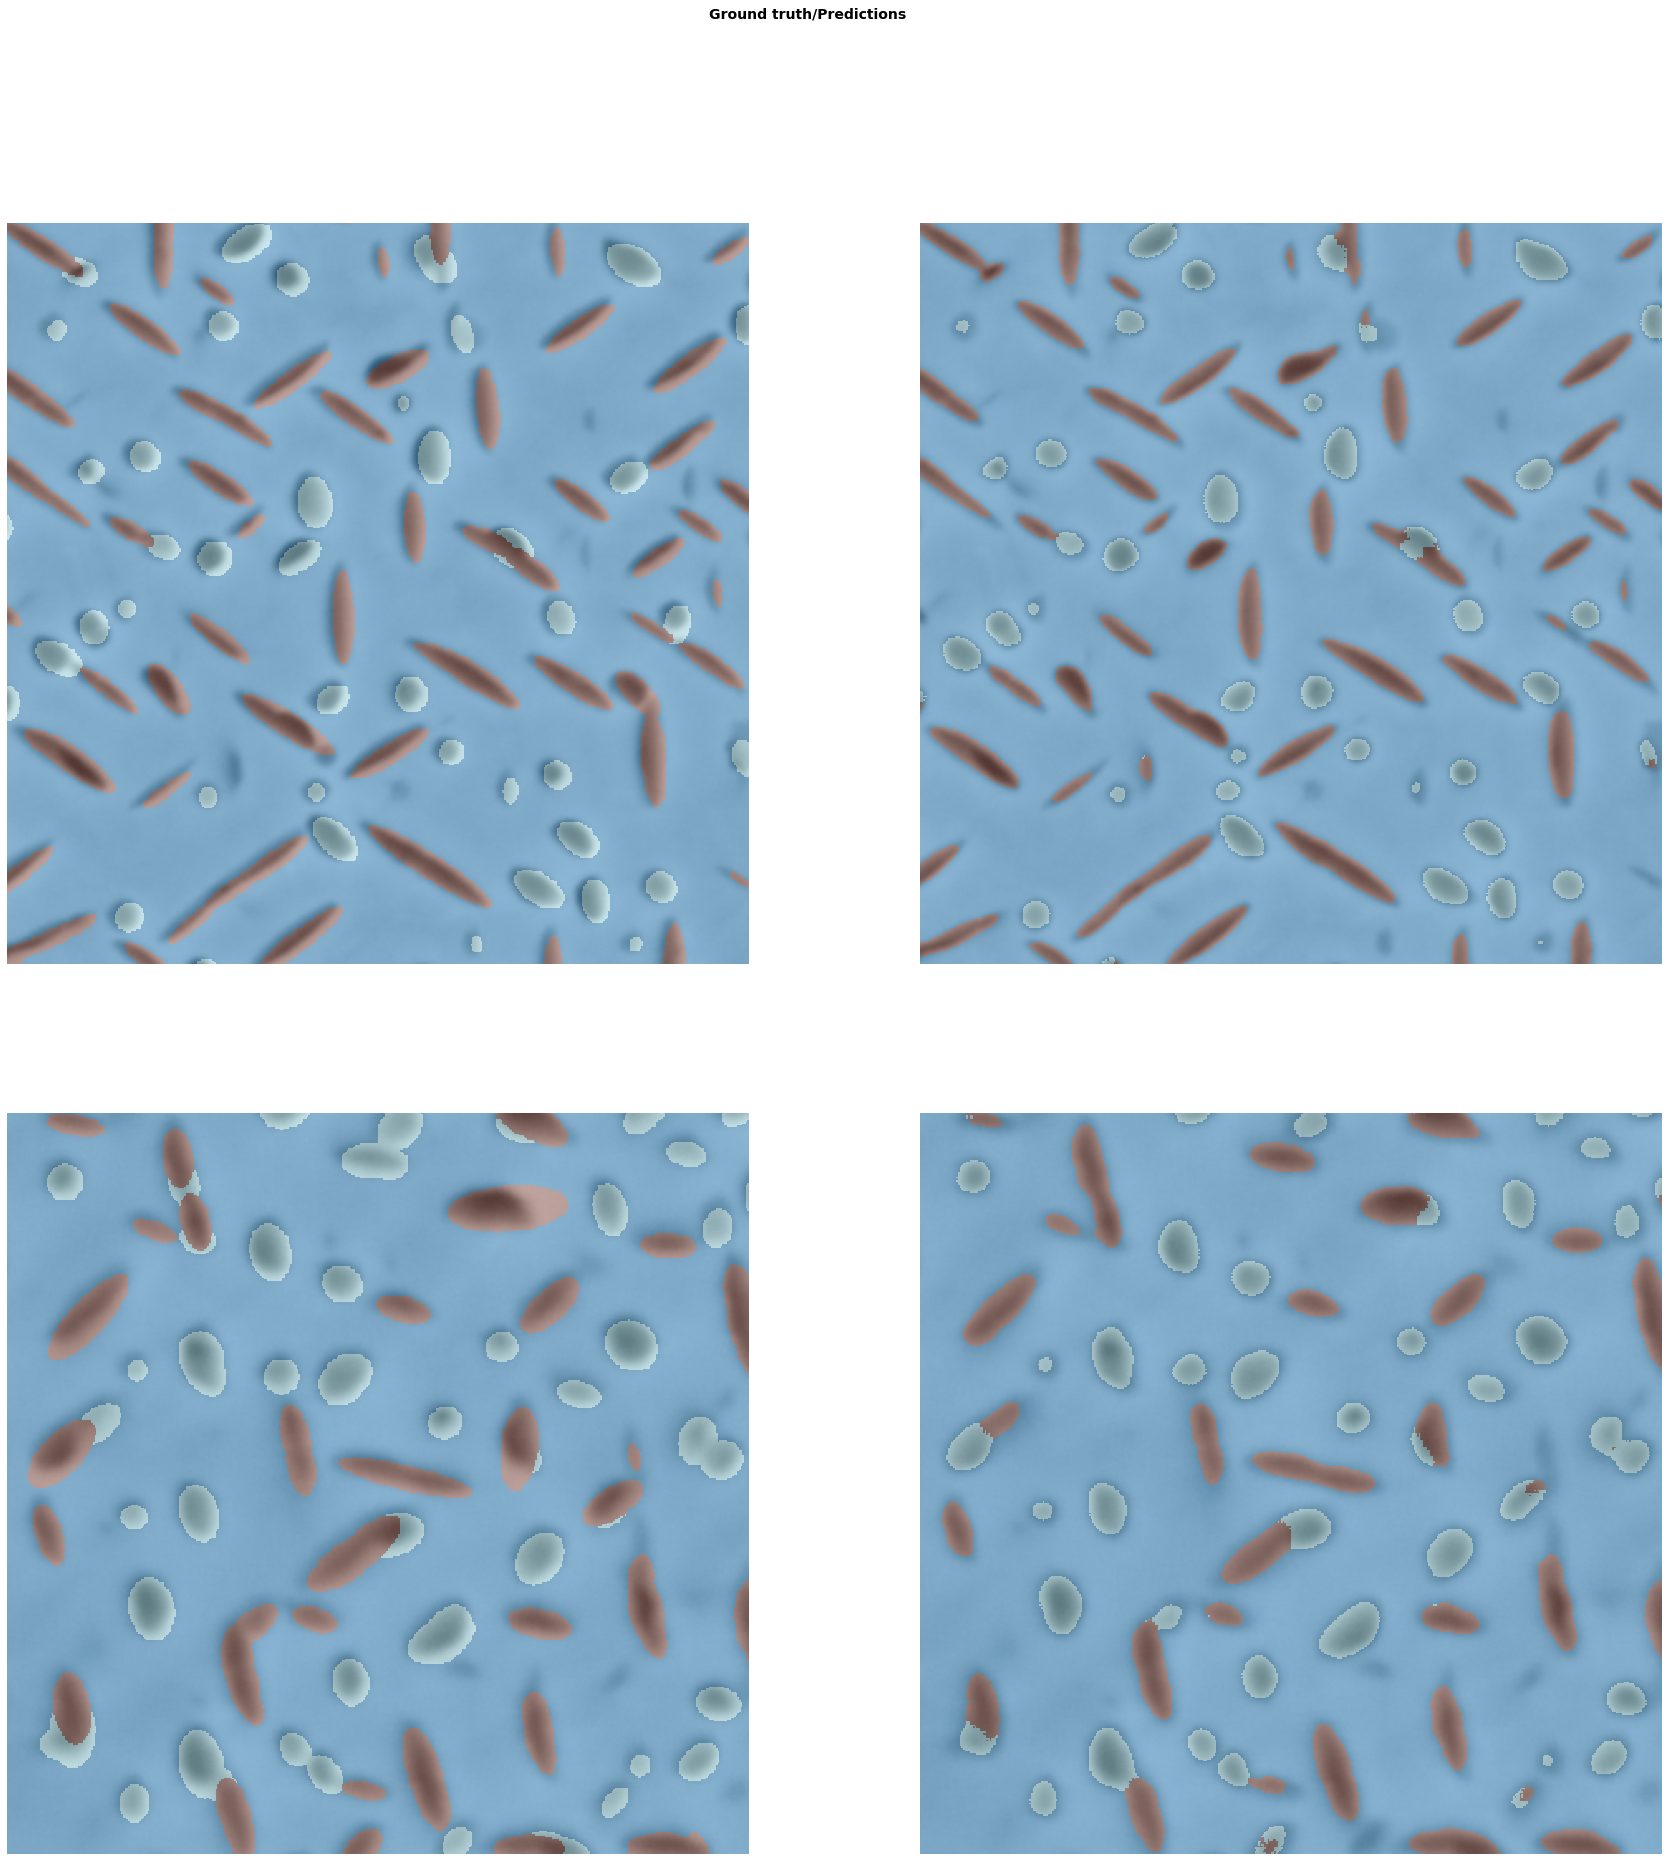

In [142]:
learn.show_results(rows=3, figsize=(30,30))

In [143]:
learn.save('stage-1-big')

In [144]:
learn.load('stage-1-big');

In [145]:
learn.unfreeze()

In [146]:
lrs = slice(1e-6,lr/10)

In [147]:
learn.fit_one_cycle(10, lrs)

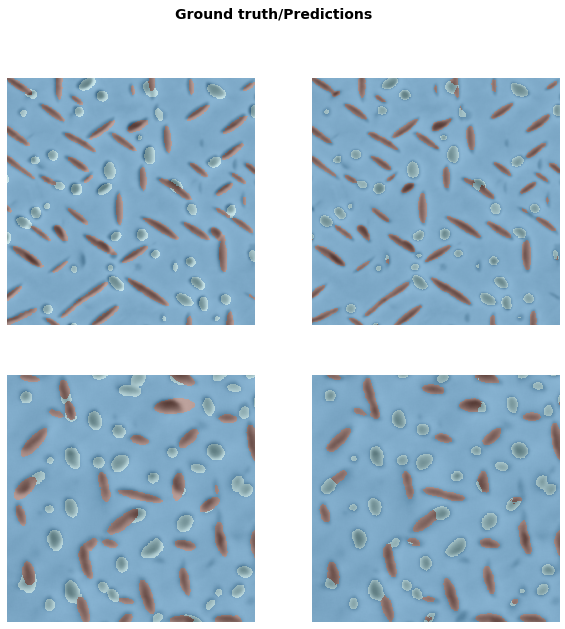

In [148]:
learn.show_results(rows=3, figsize=(10,10))

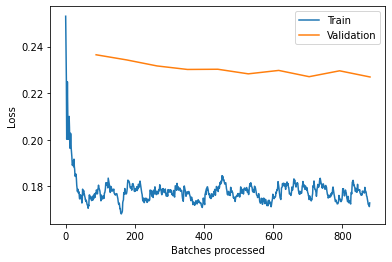

In [149]:

learn.recorder.plot_losses()

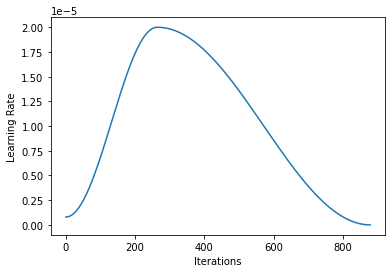

In [150]:
learn.recorder.plot_lr()

In [152]:
learn.save('stage-2-big')

In [157]:
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)

In [158]:
lr_find(learn)
learn.recorder.plot()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.91 GiB total capacity; 11.18 GiB already allocated; 4.88 MiB free; 11.20 GiB reserved in total by PyTorch)